<h1><center> TP1 : Fonctions de base pour l'apprentissage supervisé. </center></h1>

Le but de ce premier TP est de se familiariser avec la classe 'sklearn' de Python. En particulier, nous présentons les algorithmes d'apprentissage supervisé les plus populaires.

La PARTIE 1 est une liste de commandes qui doivent être suivies étape par étape. La PARTIE 2 est un problème ouvert pour lequel nous attendons votre créativité! 

# Packages importés

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MaxAbsScaler, StandardScaler,MinMaxScaler
from sklearn.metrics import balanced_accuracy_score,zero_one_loss,log_loss,hinge_loss, make_scorer, confusion_matrix
from sklearn.ensemble import RandomForestClassifier



%matplotlib notebook

#  PARTIE 1 -- MNIST


Dans la première partie du TP1, nous avons les objectifs suivants:
1. Appliquer des algorithmes de ML standard sur des données de référence standards
2. Apprendre les moyens de base de visualisation de données
3. Se familiariser avec GridSearchCV et Pipeline de sklearn

# Chargement des données

L'ensemble de données MNIST se compose d'images en noir et blanc de chiffres manuscrits de $0$ à $9$ de taille $28 \times 28$.
Dans cet exercice, nous travaillerons avec une petite partie du jeu de données MNIST original. 

Si vous êtes intéressé par l'ensemble de données, exécutez les commandes suivantes 
```python
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=custom_data_home)
```

Ainsi, les observations $(X_1, Y_1), \ldots, (X_n, Y_n)$ sont telles que $X_i \in \mathbb{R}^{784}$ and $Y_i \in \{0, \ldots, 9\}$. Pour être plus précis, chaque composante du vecteur $X_i$ est un nombre entre $0$ et $255$, qui désigne le niveau de gris. 

Le but initial est de construire un classifier $ \hat g $, qui reçoit une nouvelle image $ X $ et renvoie le nombre présent sur l'image.

In [3]:
X_train = np.load('data/mnist1_features_train.npy', allow_pickle=True)
y_train = np.load('data/mnist1_labels_train.npy', allow_pickle=True)
X_test = np.load('data/mnist1_features_test.npy', allow_pickle=True)
y_test = np.load('data/mnist1_labels_test.npy', allow_pickle=True)

n_samples, n_features = X_train.shape # extraire les dimensions de la matrice de conception 
print('Train data contains: {} samples of dimension {}'.format(n_samples, n_features))
print('Test data contains: {} samples'.format(X_test.shape[0]))

Train data contains: 2000 samples of dimension 784
Test data contains: 200 samples


# Regarder les données

Puisque chaque observation est en fait une image, nous pouvons la visualiser.

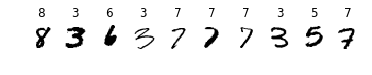

In [4]:
axes = plt.subplots(1, 10)[1]  # crée une grille de 10 plots

# Plus de détails sur la fonction zip() se trouvent ici https://docs.python.org/3.3/library/functions.html#zip
images_and_labels = list(zip(X_train, y_train)) 
for ax, (image, label) in zip(axes, images_and_labels[:10]):
    ax.set_axis_off()
    ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('{}'.format(label))

In [5]:
for i in range(10):
    print('Number of {}s in the train dataset is {}'.format(i, np.sum([y_train == str(i)])))

Number of 0s in the train dataset is 196
Number of 1s in the train dataset is 226
Number of 2s in the train dataset is 214
Number of 3s in the train dataset is 211
Number of 4s in the train dataset is 187
Number of 5s in the train dataset is 179
Number of 6s in the train dataset is 175
Number of 7s in the train dataset is 225
Number of 8s in the train dataset is 186
Number of 9s in the train dataset is 201


De ce qui précède, nous concluons que l'ensemble de données est plutôt équilibré, c'est-à-dire que chaque classe contient une quantité similaire d'observations. La classe la plus rare est $ y = 6 $ avec des exemples $ 175 $ et la classe la plus courante est $ y = 2 $ avec des exemples $ 226 $ 

# Validation Croisée (Cross-validation) avec GridSearchCV


**Question:** Expliquez ce qui se passe lorsque vous exécutez la commande 
```python
clf.fit(X_train, y_train)
```
Quelle est la complexité de chacun des trois cas suivants? 

l'exécution de clf.fit(X_train, y_train) permet d'appliquer l'algorithme KNN à la base train, et de construire le modèle

In [5]:
# GridSearchCV avec kNN : a cas simple
knn = KNeighborsClassifier() # definir un classifier
parameters = {'n_neighbors': [1, 2, 3, 4, 5]} # definir l'espace des paramètres
clf = GridSearchCV(knn, parameters, cv=3)
clf.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf.best_params_))
print('Best classification accuracy in train is: {}'.format(clf.best_score_))
print('Classification accuracy on test is: {}'.format(clf.score(X_test, y_test)))

Returned hyperparameter: {'n_neighbors': 1}
Best classification accuracy in train is: 0.891497944721333
Classification accuracy on test is: 0.875


**Question:** Quelle est la précision sur l'échantillon test? Quelle serait la précision si on prédisait le label de manière aléatoire? 

**Reponse :**
le taux d'exactitude  est de 0.875.
Il serait de 0.1 si on pédisiait de manière  aléatoire le label puisque on a 10 classes dans notre base. et chaque classe aura une probabilité de 1/10 d'être tiré


**Question:** Qu'est-ce que le ``` LinearSVC()``` classifier ? Quel noyau (kernel) a-t-on utilisé ? Que représente le paramètre ``C'' ? (c'est une question délicate, essayez de trouver la réponse en ligne) 

**Reponse :** Les machines à vecteurs de support (SVM : Support Vector Machines) sont une classe de méthodes d’apprentissage statistique basées sur le principe de la maximisation de la marge (séparation des classes). Il existe plusieurs formulations (linéaires, versions à noyaux) qui peuvent s’appliquer sur des données séparables (linéairement) mais aussi sur des données non séparables.
LinearSVC() est la formulation linéaire des SVM

Le noyau utilisé est `Kernel=Linear`. Le `C` est l'un des hyperParamètres utilisé lors de la validation qui consiste à jauger le taux ou la marge d'erreur. On cherche à minimiser le parametre ` C` le plus possible (par exemple la distance en les points et une droite).

C représente la base logarithme de 17 valeurs comprises entre 2exposant-8 et 2exposant8. Il permet d'intégrer plusieurs paramètres dans le modèle pour l'optimiser

**Question:** Quelle est la sortie de ```np.logspace(-8, 8, 17, base=2)``` ? Plus généralement, quel est le résultat de ```np.logspace(-a, b, k, base=m)``` ?

**Reponse:** Cela crée un vecteur contenant 17 points en base de 2 entre [2^-8  2^8]. De ce fait, pour `np.logspace(-a, b, k, base=m)`on aurait un vecteur de k-element(s) en base de m dans un intervalle [-a, b]

In [7]:
np.logspace(-8, 8, 17, base=2)

array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])

In [8]:
np.logspace(-8, 8, 17, base=6)

array([5.95374181e-07, 3.57224508e-06, 2.14334705e-05, 1.28600823e-04,
       7.71604938e-04, 4.62962963e-03, 2.77777778e-02, 1.66666667e-01,
       1.00000000e+00, 6.00000000e+00, 3.60000000e+01, 2.16000000e+02,
       1.29600000e+03, 7.77600000e+03, 4.66560000e+04, 2.79936000e+05,
       1.67961600e+06])

In [6]:
# SVM Classifier
svc = LinearSVC(max_iter=20000)
parameters2 = {'C': np.logspace(-8, 8, 17, base=2)} # definir l'espace des paramètres
clf2 = GridSearchCV(svc, parameters2, cv=3)
clf2.fit(X_train, y_train)


print('Returned hyperparameter: {}'.format(clf2.best_params_))
print('Best classification accuracy in train is: {}'.format(clf2.best_score_))
print('Classification accuracy on test is: {}'.format(clf2.score(X_test, y_test)))

Returned hyperparameter: {'C': 0.00390625}
Best classification accuracy in train is: 0.8095074084579332
Classification accuracy on test is: 0.795


**Question** Quelle est la signification des warnings? Quel est la paramètre responsable de cet affichage?

**Reponse :** Les warnings signifient que l'algorithme a rencontré des problèmes lors de l'execution. De ce qui precede c'est le parametre max_iter (Nombre d'iteration) qui est à l'origine des warnings. Ici, le nombre d'iteration est est de 5000. En choisissant max_iter=30 000 cela fonctionne parfaitement.

In [10]:
# SVM Classifier + Pipeline
pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters3 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # définir l'espace des paramètres
clf3 = GridSearchCV(pipe, parameters3, cv=3)
clf3.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf3.best_params_))
print('Best classification accuracy in train is: {}'.format(clf3.best_score_))
print('Classification accuracy on test is: {}'.format(clf3.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best classification accuracy in train is: 0.863002432717575
Classification accuracy on test is: 0.84


**Question:** Qu'avons-nous changé par rapport à la précédente exécution de ```LinearSVC()```?

**Question:** Expliquez ce qui se passe si on exécute
```python
    pipe.fit(X_train, y_train)
    pipe.predict(X_test, y_test)
```

**Reponse :** on a normalisé les variables dans le second cas avant d'appliquer l'algorithme. on a aussi changé le linearSVC() en SVC

pipe.fit(X_train, y_train) normalise les données de X_train et y_train  et applique l'algorithme svc 
pipe.predict permet de prédire les données de  y_test par X_test en tennat compte de l'apprentissage réalisé précedemment avec la base X_train

In [11]:
# Régression logistique
pipe = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(max_iter=5000))])
parameters4 = {'logreg__C': np.logspace(-8, 8, 17, base=2)} # définir l'espace des paramètres
clf4 = GridSearchCV(pipe, parameters4, cv=3)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification accuracy in train is: {}'.format(clf4.best_score_))
print('Classification accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'logreg__C': 0.0078125}
Best classification accuracy in train is: 0.8705039372205788
Classification accuracy on test is: 0.84


**Question:** Quelle est la différence entre ```StandardScaler()``` et ```MaxAbsScaler()``` ? Quelles sont les autres options de normalisation disponibles dans ```sklearn```?

**Reponse :** MaxAbsScaler() est utile dès lors que la distribution est eparse (répandu çà et là) 
et que vous avez pas mal d'outliers. il s'utilise pour les données qui n'ont pas une distribution gaussienne
alors que standardScaler est utilisé pour des données gaussiennes. Dans ce dernier cas, on soustrait de chaque valeur
la moyenne et on la divise par l'écart-type.

**Question:** en utilisant le code précédent comme exemple, obtenez une précision de test $ \geq 0.9 $. Vous pouvez utiliser n'importe quelle méthode du package sklearn. Donnez une description mathématique de la méthode choisie. Précisez et expliquez la grille des hyperparamères considérés. 

**Reponse :** Nous avons utilisé la methode random forest pour augmenter la precision sur l'echantillon test. Dans la classification logistique, la precision sur l'echantillon test est de 0.84 alors que la methode random forest offre une meilleur precision soit 0,92.

In [4]:
# Random Forest
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

random= RandomForestClassifier(random_state=0)

param = { 'n_estimators' : [100, 300],
         'max_depth' : [identify,logistic,5,6,7,9,9] } # définir l'espace des paramètres
clf4 = GridSearchCV(random, param, cv=3)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification accuracy in train is: {}'.format(clf4.best_score_))
print('Classification accuracy on test is: {}'.format(clf4.score(X_test, y_test)))


Returned hyperparameter: {'max_depth': 9, 'n_estimators': 300}
Best classification accuracy in train is: 0.9055044549797172
Classification accuracy on test is: 0.92


# Visualiser les erreurs 

Quelques méthodes de ```sklearn``` sont en mesure de fournir des probabilités pour chaque label ```predict_proba(X_test)```.

**Question** Il y a une erreur dans la partie de code suivante. Corrigez-la. 

**Reponse :**   L'erreur se trouve sur la ligne ``` axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1)))```. Il fallait juste appeler le premier element chose qu'on fait en ajoutant [0] à la ligne et cela devient 
``` axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1))[0])```

<IPython.core.display.Javascript object>


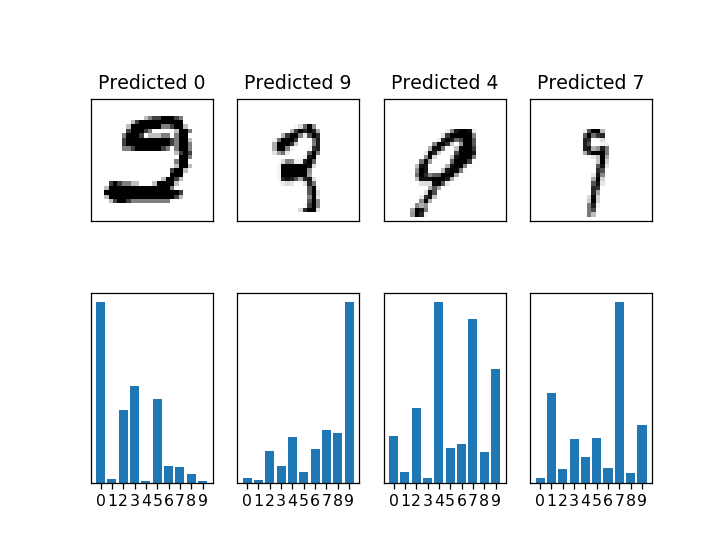

In [5]:
axes = plt.subplots(2, 4)[1]  # crée une grille de 10 plots

# Plus de détails sur la fonction zip() sont disponibles sur https://docs.python.org/3.3/library/functions.html#zip
y_pred = clf4.predict(X_test)
j = 0 # Indice qui itère sur les plots
for true_label, pred_label, image in list(zip(y_test, y_pred, X_test)):
    if j == 4: #  Nous voulons seulement regarder les 4 premières erreurs 
        break
    if true_label != pred_label:
        # Tracer les probabilités prédites 
        axes[1, j].bar(np.arange(10), clf4.predict_proba(image.reshape(1, -1))[0]) 
        axes[1, j].set_xticks(np.arange(10))
        axes[1, j].set_yticks([])
        
        # Tracer de l'image
        axes[0, j].imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        axes[0, j].set_xticks([])
        axes[0, j].set_yticks([])
        axes[0, j].set_title('Predicted {}'.format(pred_label))
        j += 1
        
#         plt.xticks(x, ('Bill', 'Fred', 'Mary', 'Sue'))
#         axex[1, j].plot()

# Changement de la fonction de perte

Il arrive souvent que la précision ne soit pas la bonne façon d'évaluer la performance. ```sklearn``` a une grande variété d'autres métriques à la fois pour la classification et la régression. Voir https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

Ici, nous voulons comprendre comment modifier la métrique de validation croisée avec un minimum d'effort. 

In [18]:
# SVM Classifier + Pipeline + New score function

pipe = Pipeline([('scaler', MaxAbsScaler()), ('svc', svc)])
parameters4 = {'svc__C': np.logspace(-8, 8, 17, base=2)} # définir l'espace des paramètres
balanced_scorer = make_scorer(balanced_accuracy_score)

clf4 = GridSearchCV(pipe, parameters3, cv=3, scoring=balanced_scorer)
clf4.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best Balanced accuracy in train is: {}'.format(clf4.best_score_))
print('Balanced accuracy on test is: {}'.format(clf4.score(X_test, y_test)))

Returned hyperparameter: {'svc__C': 0.015625}
Best Balanced accuracy in train is: 0.8612334093654231
Balanced accuracy on test is: 0.825627008328415


**Question:** Que fait ```balanced_accuracy_score```? Écrivez sa description mathématique. 

**Reponse :** ```balanced accuracy_score ``` est une métrique que l'on peut utiliser pour évaluer la qualité d'un classificateur binaire. Elle est particulièrement utile lorsque les classes sont déséquilibrées, c'est-à-dire lorsqu'une des deux classes apparaît beaucoup plus souvent que l'autre. Cela se produit souvent dans de nombreux contextes tels que la détection d'anomalies et la présence d'une maladie.

```balanced accuracy_score ``` est basée sur deux mesures plus couramment utilisées : la sensibilité (également connue sous le nom de taux de vrais positifs ou de rappel) et la spécificité (également connue sous le nom de taux de vrais négatifs, ou 1 - taux de faux positifs). La sensibilité répond à la question suivante : "Combien de cas positifs ai-je détectés ?" Ou pour le dire dans un contexte de fabrication : "Combien de produits (réellement) défectueux ai-je réussi à rappeler ?" La spécificité répond à la même question, mais pour les cas négatifs. 


elle est la moyenne arithmétique de la sensibilité et la spécificité

Parfois, il est important d'examiner la matrice de confusion de la prédiction. 

**Question:** Qu'est-ce que la matrice de confusion ? Quelles sont les conclusions que nous pouvons tirer de la  ```confusion_matrix(y_test, clf4.predict(X_test))```

In [19]:
print(confusion_matrix(y_test, clf4.predict(X_test)))

[[22  0  0  0  0  0  0  0  0  0]
 [ 0 24  0  0  0  0  0  0  2  0]
 [ 0  0 14  1  1  0  0  0  0  0]
 [ 0  0  0 18  0  3  0  0  1  1]
 [ 0  1  0  0 17  0  0  0  0  2]
 [ 1  0  0  1  0  6  0  1  0  1]
 [ 1  2  1  0  0  0 20  0  0  0]
 [ 0  0  0  0  1  0  0 15  0  0]
 [ 0  2  0  1  0  3  0  0 11  0]
 [ 0  0  0  0  2  0  0  2  1 21]]


**Reponse :** ````Une matrice de confusion```` est un résumé des résultats de prédictions sur un problème de classification. Les prédictions correctes et incorrectes sont mises en lumière et réparties par classe. Les résultats sont ainsi comparés avec les valeurs réelles.

Cette matrice permet de comprendre de quelle façon le modèle de classification est confus lorsqu’il effectue des prédictions. Ceci permet non seulement de savoir quelles sont les erreurs commises, mais surtout le type d’erreurs commises. Les utilisateurs peuvent les analyser pour déterminer quels résultats indiquent comment les erreurs sont commises.

les valeurs sur la diagonale renseigne les valeurs bien prédictes par le modèle. les autres valeursrefletent le nombre de fausse prédiction commis par le modèle
Ici on peut voir que le modèle a prédit une valeur 6 alors qu'elle était 1 Ainsi de suite 

In [92]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {'max_depth':[3,4,5]} # définir l'espace des paramètres

clf5 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3)
clf5.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf5.best_params_))
print('Best Balanced accuracy in train is: {}'.format(clf5.best_score_))
print('Balanced accuracy on test is: {}'.format(clf5.score(X_test, y_test)))


Returned hyperparameter: {'max_depth': 4}
Best Balanced accuracy in train is: 0.8775026900963933
Balanced accuracy on test is: 0.885


# PARTIE 2 -- Problème

Les données que nous avons contiennent des images provenant de $10$ classes. Normalement, la précision est un choix raisonnable pour la fonction de perte à optimiser, mais dans ce problème, nous n'aimons *vraiment* pas quand on prédit les chiffres de la classe $ \{5, 6, 7, 8, 9 \}$ dans la classe $ \{0, 1, 2, 3, 4 \} $. 

**Question:** Proposez une fonction de perte qui répondrait à nos besoins. Expliquez votre choix. 

**Question:** En suivant les exemples ci-dessus, créez un pipeline ML qui utilise *votre* fonction de perte et trouve les classifiers appropriés.

Lors de la rédaction de votre rapport sur cette partie, incluez:
    1. description de votre fonction de perte
    2. description du pipeline
    3. description des algorithmes que vous avez utilisés 

In [35]:
from sklearn.metrics import accuracy_score

**Reponse :** description de votre fonction de perte
 
   Dans la classification multi-label, cette fonction calcule la précision du sous-ensemble : l'ensemble des étiquettes prédites pour un échantillon doit correspondre exactement à l'ensemble correspondant des étiquettes dans y_true.

**Reponse :**Description du pipeline

Un Pipeline est un méta-opérateur qui permet d’enchaîner plusieurs calculs, pourvu que les classes mises à contribution 
implémentent les fonctions fit() (apprentissage) et transform() (projection). Les mécanismes de 
classes de Python et la forte cohérence des objets de « scikit-learn » font merveille ici.

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [ ]:
model = xgb.XGBClassifier()

pipeline = Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('model', model)
])

param_grid = {
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500]
}

clf_1 = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, scoring='accuracy')

clf_1.fit(X_train, y_train)


print(classification_report(y_test, y_pred))
print('Returned hyperparameter: {}'.format(clf_1.best_params_))
print('Best Score accuracy in train is: {}'.format(clf_1.best_score_))
print('Score accuracy on test is: {}'.format(clf_1.score(X_test, y_test)))

In [ ]:
pipeline.get_params().keys() # Affiche les hyperparamètre de notre pipeline

## KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [38]:
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
KNN.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'kneighborsclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'kneighborsclassifier__algorithm', 'kneighborsclassifier__leaf_size', 'kneighborsclassifier__metric', 'kneighborsclassifier__metric_params', 'kneighborsclassifier__n_jobs', 'kneighborsclassifier__n_neighbors', 'kneighborsclassifier__p', 'kneighborsclassifier__weights'])

In [39]:
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
grid_param = {'kneighborsclassifier__n_neighbors': [3,5,11,19],
             'kneighborsclassifier__weights': ['uniform', 'manhattan']
             } # définir l'espace des paramètres
balanced_scorer = make_scorer(balanced_accuracy_score)

clf5 = GridSearchCV(KNN, grid_param, cv=3, scoring=balanced_scorer)
clf5.fit(X_train, y_train)

print('Returned hyperparameter: {}'.format(clf5.best_params_))
print('Best Balanced accuracy in train is: {}'.format(clf5.best_score_))
print('Balanced accuracy on test is: {}'.format(clf5.score(X_test, y_test)))

Returned hyperparameter: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform'}
Best Balanced accuracy in train is: 0.8405833977068203
Balanced accuracy on test is: 0.8553555151157454


Commentaire du modèle KNeighborsClassifier(): 
Notre fonction nous retourne les meilleurs hyperparamètres de notre modèle.
Par exemple 'kneighborsclassifier__n_neighbors': 3  est le meilleurs paramètre utilsé parmis le dictionnaire de parametre 
'kneighborsclassifier__n_neighbors': [3,5,11,19]

'kneighborsclassifier__weights': 'uniform' est la meilleur distance utilsé.
Notre modèle à un score de : Best Balanced accuracy in train is: 0.8405833977068203.

Je peut utilsé aussi une autre méthode qui s'appelle RandomizedSearchCV pour le modélé SVC.

RandomizedSearchCV met en œuvre une méthode « fit » et « score ». Il met également en œuvre des « score_samples », « prévoir », « predict_proba », « decision_function », « transformer » et « inverse_transform » s’ils sont mis en œuvre dans l’estimateur utilisé.

Les paramètres de l’estimateur utilisé pour appliquer ces méthodes sont optimisés par une recherche validée croisée sur les paramètres.

Contrairement à GridSearchCV, toutes les valeurs de paramètres ne sont pas essayées, mais un nombre fixe de paramètres est échantillonné à partir des distributions spécifiées. Le nombre de paramètres essayés est donné par n_iter

## SVC

In [41]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report

SVM = make_pipeline(StandardScaler(), SVC(random_state=0))
SVM.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svc', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [42]:
SVM = make_pipeline(StandardScaler(), SVC(random_state=0))
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
               'svc__C':[1, 10, 100, 1000, 3000]
              }
grid = RandomizedSearchCV(SVM, hyper_params, scoring='accuracy', cv=3,
                         n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))



{'svc__gamma': 0.001, 'svc__C': 10}
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       0.92      0.88      0.90        26
           2       0.74      0.88      0.80        16
           3       0.88      0.91      0.89        23
           4       0.90      0.95      0.93        20
           5       0.83      1.00      0.91        10
           6       1.00      0.79      0.88        24
           7       0.94      1.00      0.97        16
           8       1.00      0.76      0.87        17
           9       0.92      0.88      0.90        26

    accuracy                           0.90       200
   macro avg       0.90      0.91      0.90       200
weighted avg       0.91      0.90      0.90       200



## NLP CLassifier

In [44]:
from sklearn.neural_network import MLPClassifier

In [45]:
clf = MLPClassifier(hidden_layer_sizes = [200, 200], alpha = 10,
                   random_state = 0, solver = 'lbfgs').fit(X_train, y_train)

print('Accuracy of ANN classifier on tranning set: {:.2f})'
      .format(clf.score(X_train, y_train)))

print('Accuracy of ANN classifier on test set: {:.2f})'
      .format(clf.score(X_test, y_test)))



Accuracy of ANN classifier on tranning set: 1.00)
Accuracy of ANN classifier on test set: 0.87)
